In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and preprocess the data
data = pd.read_csv('gsw.csv')
data['game_result'] = (data['pts'] > data['opp_pts']).astype(int)
data['game_location'] = data['game_location'].map({'@': 0, 'home': 1})
data['date_game'] = pd.to_datetime(data['date_game'], errors='coerce')
data['year'] = data['date_game'].dt.year
data['month'] = data['date_game'].dt.month
data['day'] = data['date_game'].dt.day
data = data.drop(['date_game', 'opp_pts', 'Team', 'x'], axis=1, errors='ignore')

# Splitting the dataset
X = data.drop('game_result', axis=1)
y = data['game_result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining hyperparameters for models
gbc_params = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
dtc_params = {'max_depth': [None, 10, 20], 'min_samples_split': [5, 10, 20, 30]}

# GridSearchCV for GradientBoostingClassifier
gbc_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gbc_params, cv=3)
gbc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)
gbc_best_params = gbc_grid_search.best_params_

# GridSearchCV for DecisionTreeClassifier
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), dtc_params, cv=3)
dtc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)
dtc_best_params = dtc_grid_search.best_params_

# Defining hyperparameters for RandomForestClassifier
rfc_params = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}

# GridSearchCV for RandomForestClassifier
rfc_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rfc_params, cv=3)
rfc_grid_search.fit(X_train.select_dtypes(include='number'), y_train)
rfc_best_params = rfc_grid_search.best_params_

# Preprocessing pipeline
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if col not in categorical_cols + ['game_result']]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

# Assembling the voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('gbc', GradientBoostingClassifier(**gbc_best_params, random_state=42)),
        ('dtc', DecisionTreeClassifier(**dtc_best_params, random_state=42)),
        ('rfc', RandomForestClassifier(**rfc_best_params, random_state=42))
    ], voting='hard')

# Pipeline for the complex model
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', voting_clf)])

# Fitting and predicting with the complex model
pipeline.fit(X_train, y_train)
complex_y_pred = pipeline.predict(X_test)
complex_model_accuracy = accuracy_score(y_test, complex_y_pred)

# Displaying accuracy of the complex model
complex_model_accuracy


0.9371428571428572

In [12]:
import numpy as np

# Assuming gbc_predictions, dtc_predictions, rfc_predictions, and complex_y_pred are already computed as per the previous steps

# Calculate the agreement between each classifier's predictions and the voting ensemble's predictions
gbc_agreement = np.mean(gbc_predictions == complex_y_pred)
dtc_agreement = np.mean(dtc_predictions == complex_y_pred)
rfc_agreement = np.mean(rfc_predictions == complex_y_pred)

# Print the agreement values
print(f"Gradient Boosting Agreement with Ensemble: {gbc_agreement:.2f}")
print(f"Decision Tree Agreement with Ensemble: {dtc_agreement:.2f}")
print(f"Random Forest Agreement with Ensemble: {rfc_agreement:.2f}")


Gradient Boosting Agreement with Ensemble: 0.95
Decision Tree Agreement with Ensemble: 0.85
Random Forest Agreement with Ensemble: 0.97


In [16]:
from sklearn.linear_model import LogisticRegression

# Training a simpler model - Logistic Regression
simple_model = LogisticRegression(max_iter=1000)
simple_model.fit(X_train.select_dtypes(include='number'), y_train)  # Using only numerical columns

# Predicting with the simpler model
simple_y_pred = simple_model.predict(X_test.select_dtypes(include='number'))

# Calculating accuracy for the simpler model
simple_model_accuracy = accuracy_score(y_test, simple_y_pred)
simple_model_accuracy
print(f"Logistic Regression: {simple_model_accuracy:.2f}")

Logistic Regression: 0.99


/Users/arpanavvari/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


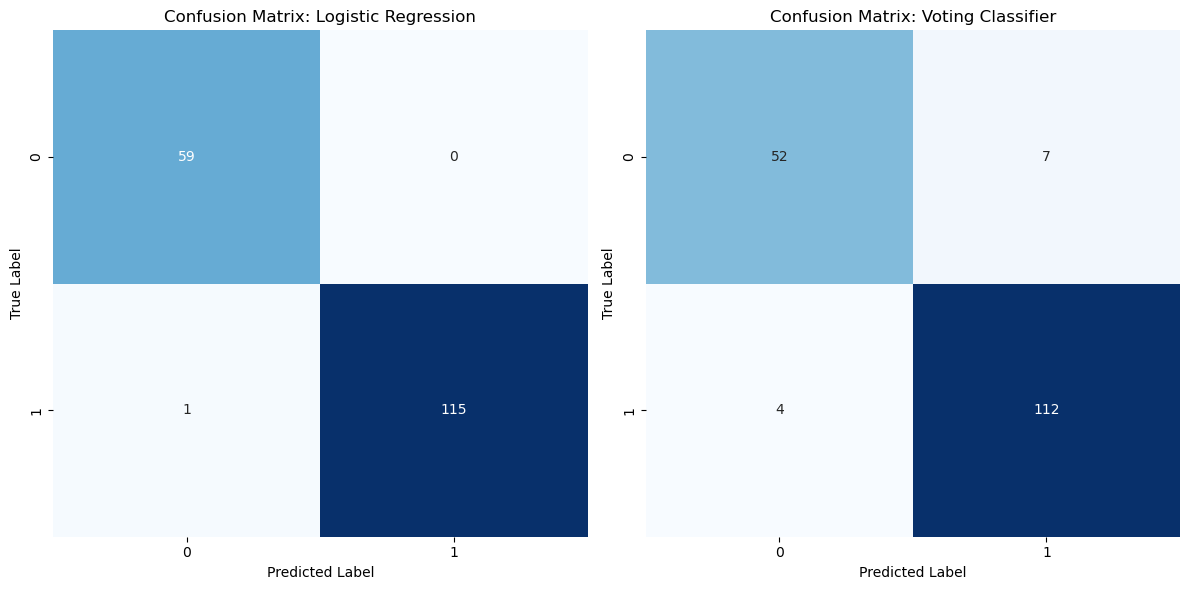

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating confusion matrices for both models
cm_simple = confusion_matrix(y_test, simple_y_pred)
cm_complex = confusion_matrix(y_test, complex_y_pred)

# Plotting the confusion matrices
plt.figure(figsize=(12, 6))

# Simple Model
plt.subplot(1, 2, 1)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Complex Model
plt.subplot(1, 2, 2)
sns.heatmap(cm_complex, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()



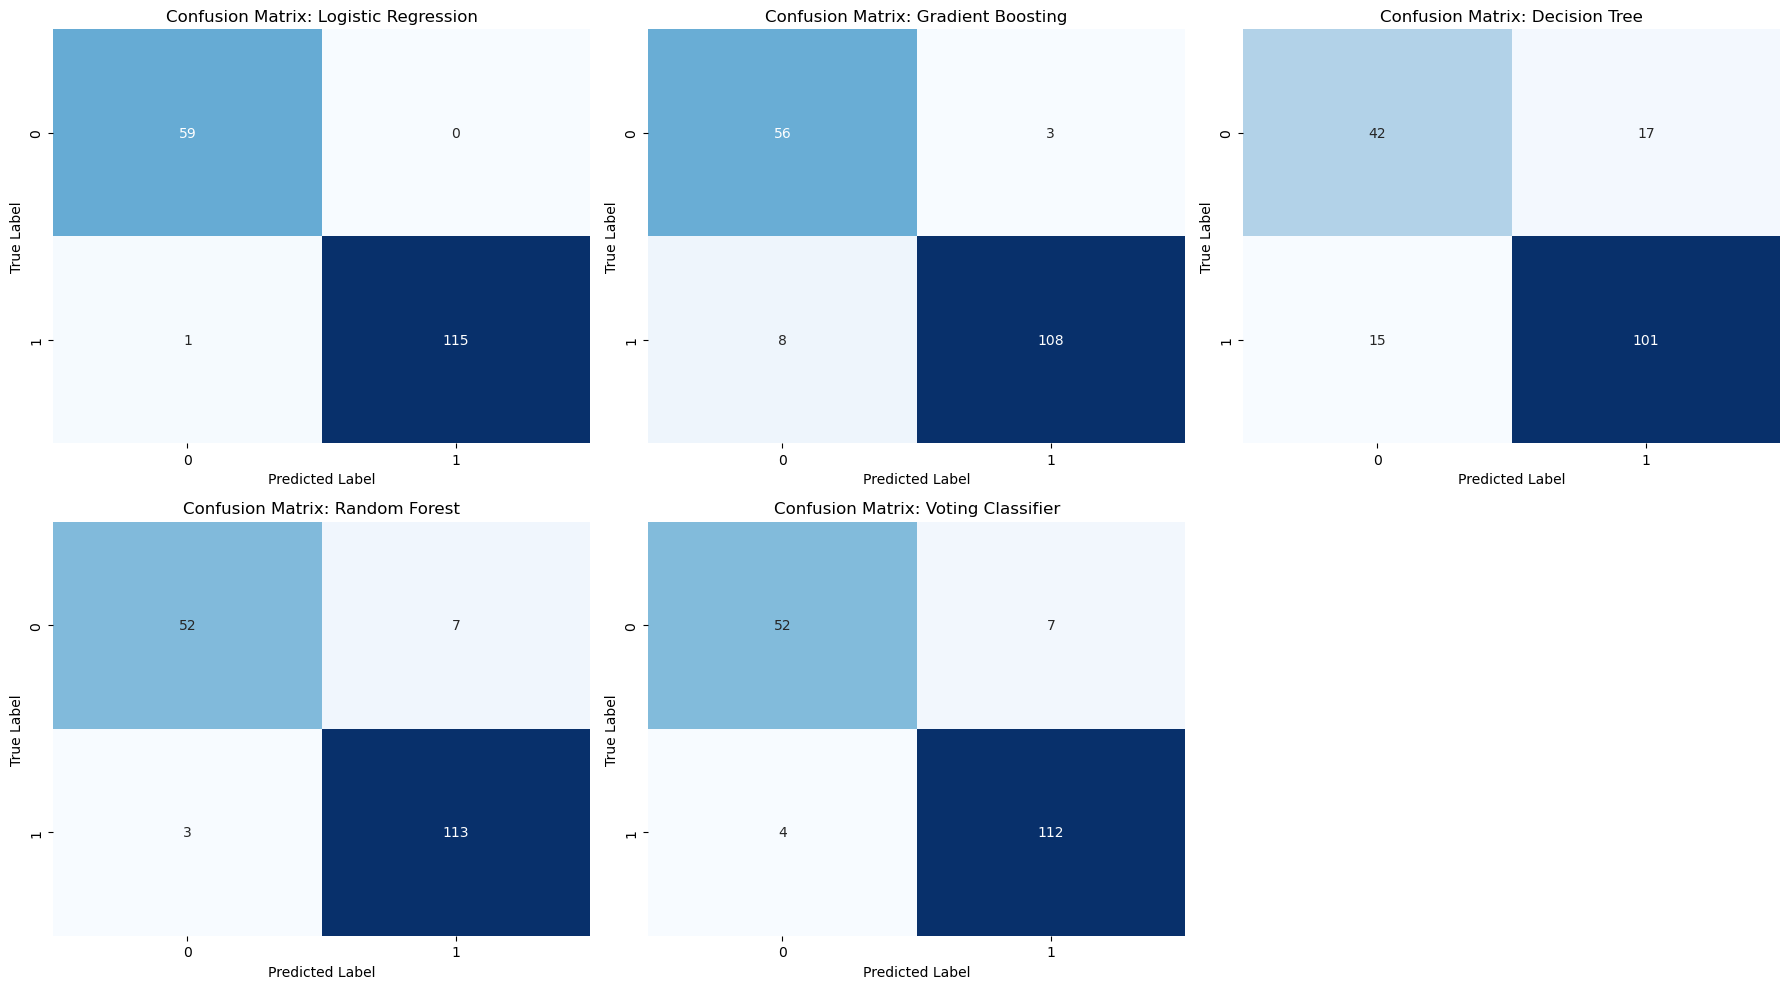

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure you have the predictions from all models
# simple_y_pred, gbc_predictions, dtc_predictions, rfc_predictions, complex_y_pred

# Calculating confusion matrices
cm_logistic_regression = confusion_matrix(y_test, simple_y_pred)
cm_gradient_boosting = confusion_matrix(y_test, gbc_predictions)
cm_decision_tree = confusion_matrix(y_test, dtc_predictions)
cm_random_forest = confusion_matrix(y_test, rfc_predictions)
cm_voting_classifier = confusion_matrix(y_test, complex_y_pred)

# Plotting the confusion matrices
plt.figure(figsize=(18, 10))

# Logistic Regression
plt.subplot(2, 3, 1)
sns.heatmap(cm_logistic_regression, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Gradient Boosting
plt.subplot(2, 3, 2)
sns.heatmap(cm_gradient_boosting, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Gradient Boosting')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Decision Tree
plt.subplot(2, 3, 3)
sns.heatmap(cm_decision_tree, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Random Forest
plt.subplot(2, 3, 4)
sns.heatmap(cm_random_forest, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Voting Classifier
plt.subplot(2, 3, 5)
sns.heatmap(cm_voting_classifier, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Voting Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()


Based on these observations, the Logistic Regression and Voting Classifier seem to be performing the best, as indicated by their confusion matrices. 

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming simple_y_pred and complex_y_pred are predictions from simple_model and complex_model
# You've already computed these in your previous code snippets

# Calculate metrics for the simple model
simple_precision = precision_score(y_test, simple_y_pred)
simple_recall = recall_score(y_test, simple_y_pred)
simple_f1 = f1_score(y_test, simple_y_pred)
simple_conf_matrix = confusion_matrix(y_test, simple_y_pred)

# Calculate metrics for the complex model
complex_precision = precision_score(y_test, complex_y_pred)
complex_recall = recall_score(y_test, complex_y_pred)
complex_f1 = f1_score(y_test, complex_y_pred)
complex_conf_matrix = confusion_matrix(y_test, complex_y_pred)

# Output results for the simple model
print("Simple Model Metrics:")
print("Precision:", simple_precision)
print("Recall:", simple_recall)
print("F1-Score:", simple_f1)
print("Confusion Matrix:\n", simple_conf_matrix)
print(classification_report(y_test, simple_y_pred))

# Output results for the complex model
print("\nComplex Model Metrics:")
print("Precision:", complex_precision)
print("Recall:", complex_recall)
print("F1-Score:", complex_f1)
print("Confusion Matrix:\n", complex_conf_matrix)
print(classification_report(y_test, complex_y_pred))


Simple Model Metrics:
Precision: 1.0
Recall: 0.9913793103448276
F1-Score: 0.9956709956709957
Confusion Matrix:
 [[ 59   0]
 [  1 115]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      0.99      1.00       116

    accuracy                           0.99       175
   macro avg       0.99      1.00      0.99       175
weighted avg       0.99      0.99      0.99       175


Complex Model Metrics:
Precision: 0.9411764705882353
Recall: 0.9655172413793104
F1-Score: 0.9531914893617022
Confusion Matrix:
 [[ 52   7]
 [  4 112]]
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        59
           1       0.94      0.97      0.95       116

    accuracy                           0.94       175
   macro avg       0.93      0.92      0.93       175
weighted avg       0.94      0.94      0.94       175



In [19]:

#  calculate precision, recall, and F1-score for each model as follows:

# Logistic Regression Metrics
lr_precision = precision_score(y_test, simple_y_pred)
lr_recall = recall_score(y_test, simple_y_pred)
lr_f1 = f1_score(y_test, simple_y_pred)
lr_conf_matrix = confusion_matrix(y_test, simple_y_pred)

# Gradient Boosting Metrics
gbc_precision = precision_score(y_test, gbc_predictions)
gbc_recall = recall_score(y_test, gbc_predictions)
gbc_f1 = f1_score(y_test, gbc_predictions)
gbc_conf_matrix = confusion_matrix(y_test, gbc_predictions)

# Decision Tree Metrics
dtc_precision = precision_score(y_test, dtc_predictions)
dtc_recall = recall_score(y_test, dtc_predictions)
dtc_f1 = f1_score(y_test, dtc_predictions)
dtc_conf_matrix = confusion_matrix(y_test, dtc_predictions)

# Random Forest Metrics
rfc_precision = precision_score(y_test, rfc_predictions)
rfc_recall = recall_score(y_test, rfc_predictions)
rfc_f1 = f1_score(y_test, rfc_predictions)
rfc_conf_matrix = confusion_matrix(y_test, rfc_predictions)

# Voting Classifier Metrics
voting_precision = precision_score(y_test, complex_y_pred)
voting_recall = recall_score(y_test, complex_y_pred)
voting_f1 = f1_score(y_test, complex_y_pred)
voting_conf_matrix = confusion_matrix(y_test, complex_y_pred)

# Print the metrics for each model
print("Logistic Regression Metrics:")
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1-Score:", lr_f1)
print("Confusion Matrix:\n", lr_conf_matrix)
print(classification_report(y_test, simple_y_pred))

print("\nGradient Boosting Metrics:")
print("Precision:", gbc_precision)
print("Recall:", gbc_recall)
print("F1-Score:", gbc_f1)
print("Confusion Matrix:\n", gbc_conf_matrix)
print(classification_report(y_test, gbc_predictions))

print("\nDecision Tree Metrics:")
print("Precision:", dtc_precision)
print("Recall:", dtc_recall)
print("F1-Score:", dtc_f1)
print("Confusion Matrix:\n", dtc_conf_matrix)
print(classification_report(y_test, dtc_predictions))

print("\nRandom Forest Metrics:")
print("Precision:", rfc_precision)
print("Recall:", rfc_recall)
print("F1-Score:", rfc_f1)
print("Confusion Matrix:\n", rfc_conf_matrix)
print(classification_report(y_test, rfc_predictions))

print("\nVoting Classifier Metrics:")
print("Precision:", voting_precision)
print("Recall:", voting_recall)
print("F1-Score:", voting_f1)
print("Confusion Matrix:\n", voting_conf_matrix)
print(classification_report(y_test, complex_y_pred))


Logistic Regression Metrics:
Precision: 1.0
Recall: 0.9913793103448276
F1-Score: 0.9956709956709957
Confusion Matrix:
 [[ 59   0]
 [  1 115]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      0.99      1.00       116

    accuracy                           0.99       175
   macro avg       0.99      1.00      0.99       175
weighted avg       0.99      0.99      0.99       175


Gradient Boosting Metrics:
Precision: 0.972972972972973
Recall: 0.9310344827586207
F1-Score: 0.9515418502202643
Confusion Matrix:
 [[ 56   3]
 [  8 108]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        59
           1       0.97      0.93      0.95       116

    accuracy                           0.94       175
   macro avg       0.92      0.94      0.93       175
weighted avg       0.94      0.94      0.94       175


Decision Tree Metrics:
Precision: 0.855932203389

Logistic Regression appears to be the best model given its perfect precision, highest recall, and F1-score, and its confusion matrix shows it made almost no errors. It is closely followed by the Voting Classifier and Random Forest, which have similar performance metrics but slightly more false negatives and false positives.